In [1]:
# %load main.py
import argparse
import time
import os
import os.path

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
from utility.utility import postp, GramMatrix, GramMSELoss, load_images, save_images, make_folders
from utility.loss_fns import get_style_patch_weights, patch_difference, mrf_loss_fn, weight_maker
from utility.vgg_network import VGG

In [2]:
# style weights
sw1=1
sw2=1
sw3=1
sw4=1
sw5=1
# Content weights
cw1=0
cw2=0
cw3=0
cw4=1e5
cw5=0
#############################################################################
# Get image paths and names
# Style 1
style_dir1  = os.path.dirname('../input/font_contents/serif/A/Milonga-Regular.png')
style_name1 = os.path.basename('../input/font_contents/serif/A/Milonga-Regular.png')
# Style 2
style_dir2  = os.path.dirname('../input/font_contents/serif_rmv/A/Milonga-Regular.png')
style_name2 = os.path.basename('../input/font_contents/serif_rmv/A/Milonga-Regular.png')
# Content
content_dir  = os.path.dirname('../input/font_contents/AlegreyaSans-Light/A.png')
content_name = os.path.basename('../input/font_contents/AlegreyaSans-Light/A.png')

# Cuda device
if torch.cuda.is_available:
    device = 'cuda:0'
else:
    device = 'cpu'
print("Using device: ", device)

# Parameters
alpha = 1
beta = 1
patch_size = 5
image_size = 256
content_invert = 1
style_invert = 1
result_invert = content_invert

# Get output path
output_path = '../output_style_difference/test/'
try:
    os.mkdir(output_path)
except:
    pass
output_path = output_path + content_name[:-4] + '_' + style_name1[:-4] + '_' + style_name2[:-4] + '/'

Using device:  cuda:0


In [3]:
# Get network
vgg = VGG()
vgg.load_state_dict(torch.load('../Models/vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

# Load images
content_image = load_images(os.path.join(content_dir, content_name), image_size, device, content_invert)
style_image1  = load_images(os.path.join(style_dir1,style_name1), image_size, device, style_invert)
style_image2  = load_images(os.path.join(style_dir2,style_name2), image_size, device, style_invert)

# Random input
# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data).to(device), requires_grad=True).to(device)
# Content input
opt_img = Variable(content_image.data.clone(), requires_grad=True)

#### Define layers, loss functions, weights and compute optimization targets

In [4]:
# Style layers
# style_layers = ['r11','r21','r31','r41','r51'] 
style_layers = []
style_weights = [sw*1e3/n**2 for sw,n in zip([sw1,sw2,sw3,sw4,sw5],[64,128,256,512,512])]
# Content layers
# content_layers = ['r12','r22','r32','r42','r52']
# content_weights = [cw1*1e5,cw2*1e5,cw3*1e5,cw4*1e5,cw5*1e5]
content_layers = ['r42']
content_weights = [cw4*1e4]
# Patch layers
patch_layers = ['r31','r41']

# Combine all loss layers
loss_layers = style_layers + content_layers + patch_layers
# Loss functions for style and content loss
loss_functions = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_functions = [loss_fn.to(device) for loss_fn in loss_functions]
weights = style_weights + content_weights

#### Compute optimization targets

In [5]:
## Gram matrix targets
#### Feature maps from style layers of the style images
style1_fms_style = [A.detach() for A in vgg(style_image1, style_layers)]
style2_fms_style = [A.detach() for A in vgg(style_image2, style_layers)]
#### Difference between feature maps
style_fms_style  = [style1_fms_style[i] - style2_fms_style[i] for i in range(len(style_layers))]
#### Gram matrix of difference feature maps
gramm_style = [GramMatrix()(A) for A in style_fms_style]
#### Feature maps from style layers of the content image
content_fms_style = [A.detach() for A in vgg(content_image, style_layers)]

style_target = [GramMatrix()(style1_fms_style[i])-GramMatrix()(style2_fms_style[i]) for i in range(len(style_layers))]

In [6]:
## Content targets

#### Feature maps from content layers of the style images
style1_fms_content = [A.detach() for A in vgg(style_image1, content_layers)]
style2_fms_content = [A.detach() for A in vgg(style_image2, content_layers)]
#### Difference between feature maps
style_fms_content = [style1_fms_content[i] - style2_fms_content[i] for i in range(len(content_layers))]
#### Feature maps from content layers of the content image
content_fm_content = [A.detach() for A in vgg(content_image, content_layers)]

In [7]:
## Patch targets

#### Feature maps from patch layers of the style images
style1_fms_patch = [A.detach() for A in vgg(style_image1, patch_layers)]
style2_fms_patch = [A.detach() for A in vgg(style_image2, patch_layers)]
#### Patches extracted from the feature maps
style1_patches_lists, style1_weight_list = get_style_patch_weights(style1_fms_patch, device, k=patch_size)
style2_patches_lists, style2_weight_list = get_style_patch_weights(style2_fms_patch, device, k=patch_size)
#### Difference between corresponding patches
diff_patches_list1, diff_patches_list2 = patch_difference(style1_patches_lists,style2_patches_lists)
#### Locate different patches of style1 & style2
style1_different_patches256 = []
style2_different_patches256 = []
for p1, p2 in zip(style1_patches_lists[0], style2_patches_lists[0]):
    if not torch.eq(p1,p2).all():
        style1_different_patches256.append(p1)
        style2_different_patches256.append(p2)
style1_different_patches512 = []
style2_different_patches512 = []
for p1, p2 in zip(style1_patches_lists[1], style2_patches_lists[1]):
    if not torch.eq(p1,p2).all():
        style1_different_patches512.append(p1)
        style2_different_patches512.append(p2)
style1_different_patches = [style1_different_patches256, style1_different_patches512]

#### Feature maps from patch layers of the content image
content_fms_patch = [A.detach() for A in vgg(content_image, patch_layers)]
#### Patches extracted from the feature maps
content_patches_lists, content_weight_list = get_style_patch_weights(style1_fms_patch, device, k=patch_size)

Integrate different patches to content patches

In [8]:
combined_patches_lists = [content_patches_lists[0]+style1_different_patches256,content_patches_lists[1]+style1_different_patches512]
# Create weights to use for convolution, in per channel size
weight_list = [weight_maker(style_plist,patch_size,device) for style_plist in combined_patches_lists]

In [9]:
# Run style transfer
make_folders(output_path)

max_iter = 600
show_iter = 50
optimizer = optim.LBFGS([opt_img])
n_iter=[0]
loss_list = []
c_loss = []
s_loss = []
p_loss = []

In [10]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        content_layer_losses = []
        style_layer_losses  = []
        
        # Divide between style feature maps, content feature maps and patch feature maps
        opt_fms_style = out[:len(style_layers)]
        opt_fms_content = out[len(style_layers):len(style_layers)+len(content_layers)]
        opt_fms_patch = out[-len(patch_layers):]

        # Difference between feature maps on style layers
        diff_fms_style = [opt_fms_style[i] - content_fms_style[i] for i in range(len(style_layers))]
        gramm_diff = [GramMatrix()(A) for A in diff_fms_style]
        # Difference between gram matrix of feature map differences
        style_layer_losses = [style_weights[i]*(nn.MSELoss()(gramm_diff[i], gramm_style[i])) for i in range(len(style_layers))]

        ## Difference between feature maps on content layers
        fms_diff = [opt_fms_content[i] - content_fm_content[i] for i in range(len(content_layers))]
        content_layer_losses = [content_weights[i]*nn.MSELoss()(fms_diff[i],style_fms_content[i]) for i in range(len(content_layers))]


        ## Differnce between the patches
        #### Patches extracted from the opt feature maps
        opt_patches_lists, opt_weight_list = get_style_patch_weights(opt_fms_patch, device, k=patch_size)
        #### Difference between corresponding patches with content patches
#         diff_patches_list1_1, diff_patches_list2_2 = patch_difference(opt_patches_lists,content_patches_lists)

        #### Patch loss
#         patch_layer_losses = []
#         for i in range(len(diff_patches_list1)):
#             patch_layer_losses.append(nn.MSELoss()(diff_patches_list1_1[i],diff_patches_list1[i]))
#         for i in range(len(diff_patches_list2)):
#             patch_layer_losses.append(nn.MSELoss()(diff_patches_list2_2[i],diff_patches_list2[i]))
        patch_layer_losses = [mrf_loss_fn(opt_fms_patch, combined_patches_lists, weight_list, k=patch_size)]


        # losses
        content_loss = sum(content_layer_losses)
        style_loss   = sum(style_layer_losses)
        patch_loss   = sum(patch_layer_losses)

        loss = style_loss + content_loss + patch_loss
        # layer_losses = content_layer_losses + style_layer_losses + patch_layer_losses

        # # total loss
        # loss = sum(layer_losses)

        # for log
        c_loss.append(content_loss)
        s_loss.append(style_loss)
        p_loss.append(patch_loss)
        loss_list.append(loss)

        # backward calculation
        loss.backward()

        #print loss
        if n_iter[0]%show_iter == 0:
            print('Iteration: {}'.format(n_iter[0]))
            if len(content_layers)>0: print('Content loss: {}'.format(content_loss.item()))
            if len(style_layers)>0:   print('Style loss  : {}'.format(style_loss.item()))
            if len(patch_layers)>0:   print('Patch loss  : {}'.format(patch_loss))
            print('Total loss  : {}'.format(loss.item()))

            # Save loss graph
            # plt.plot(loss_list, label='Total loss')
            if len(content_layers)>0:  plt.plot(c_loss, label='Content loss')
            if len(style_layers)  >0:  plt.plot(s_loss, label='Style loss')
            if len(patch_layers)  >0:  plt.plot(p_loss, label='Patch loss')
            plt.legend()
            plt.savefig(output_path + 'loss_graph.jpg')
            plt.close()
            # Save optimized image
            out_img = postp(opt_img.data[0].cpu().squeeze(), image_size, result_invert)
            out_img.save(output_path + 'outputs/{}.bmp'.format(n_iter[0]))
        n_iter[0] += 1
        return loss
      
    optimizer.step(closure)

Iteration: 0
Content loss: 115087314518016.0
Patch loss  : 2619749695488.0
Total loss  : 117707068407808.0
Iteration: 50
Content loss: 40052704935936.0
Patch loss  : 3376196616192.0
Total loss  : 43428901552128.0
Iteration: 100
Content loss: 30330222280704.0
Patch loss  : 3144774582272.0
Total loss  : 33474996076544.0
Iteration: 150
Content loss: 26623613075456.0
Patch loss  : 3038604427264.0
Total loss  : 29662218551296.0
Iteration: 200
Content loss: 24731849850880.0
Patch loss  : 2972756213760.0
Total loss  : 27704606851072.0
Iteration: 250
Content loss: 23120991748096.0
Patch loss  : 2908967927808.0
Total loss  : 26029959675904.0
Iteration: 300
Content loss: 22075485978624.0
Patch loss  : 2859942805504.0
Total loss  : 24935428784128.0
Iteration: 350
Content loss: 21406634999808.0
Patch loss  : 2821454823424.0
Total loss  : 24228090871808.0
Iteration: 400
Content loss: 20771179069440.0
Patch loss  : 2782000054272.0
Total loss  : 23553179123712.0
Iteration: 450
Content loss: 201013717

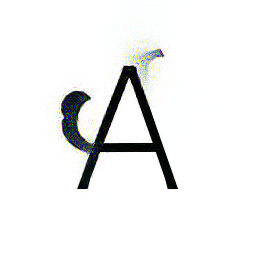

In [11]:
postp(opt_img.data[0].cpu().squeeze(), image_size, result_invert)

In [ ]:
# Save sum images
save_images(content_image.data[0].cpu().squeeze(), opt_img.data[0].cpu().squeeze(), style_image1.data[0].cpu().squeeze(), style_image2.data[0].cpu().squeeze(), image_size, output_path, n_iter, content_invert, style_invert, result_invert)

In [ ]:
# Save sum images
save_images(content_image.data[0].cpu().squeeze(), opt_img.data[0].cpu().squeeze(), style_image1.data[0].cpu().squeeze(), style_image2.data[0].cpu().squeeze(), image_size, output_path, n_iter, content_invert, style_invert, result_invert)

In [12]:
# Save sum images
save_images(content_image.data[0].cpu().squeeze(), opt_img.data[0].cpu().squeeze(), style_image1.data[0].cpu().squeeze(), style_image2.data[0].cpu().squeeze(), image_size, output_path, n_iter, content_invert, style_invert, result_invert)